### Bo's Dataset and Toronto Centrelines
This file loads Bo's dataset/shapefile for cycling stress classification:<br>
(https://github.com/lin-bo/Toronto_LTS_network) <br>
It also loads in Toronto road shapefile taken from Toronto's Open Data Portal: <br>
(https://open.toronto.ca/dataset/neighbourhood-profiles/) <br>
(https://open.toronto.ca/dataset/neighbourhoods/) <br>

Work performed:
- load data (shapefile and Bo's LTS data targets).
- perform EDA to see if the road type could be used as a feature. Use dummy encoding.

#### Imports:

In [58]:
# Import 3rd party libraries
import os
import json
import requests
import numpy as np
import pandas as pd
import seaborn as sns
import geopandas as gpd
import matplotlib.pyplot as plt

# Configure Notebook
%matplotlib inline
#plt.style.use('dark_background')
plt.style.use('seaborn-colorblind')
#plt.style.use('ggplot')
sns.set_context("notebook")
import warnings
warnings.filterwarnings('ignore')

#### Import the raw data into a dataframe
Import both Bo's data and the centrelines with corresponding feature names

(59554, 12)


<AxesSubplot:>

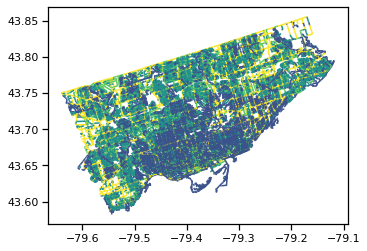

In [59]:
# import Bo's shapefile
file_path_keagan = 'C:/Users/Keagan Rankin/Documents/PycharmProj/data/raw_data/Bo Github Data/centerline_LTS_July2021.shp'
file_path_saad = 'insert here for ease'
lts_gpd = gpd.read_file(file_path_keagan)
print(lts_gpd.shape)
lts_gpd.plot(column='LTS')

In [60]:
#Import the shapefile from open Toronto (see eda_toronto_centrelines)
geojsonpath = 'C:/Users/keaga/PycharmProjects/1498-ML-Project/data/raw_data/centreline_wgs84_geojson_v2/CENTRELINE_WGS84.geojson'
path2 = 'C:/Users/Keagan Rankin/Documents/PycharmProj/data/raw_data/centreline_wgs84_geojson_v2/CENTRELINE_WGS84.geojson'
centrelines_gpd = gpd.read_file(path2)

centrelines_gpd.head(2)

,CENTRELINE_ID,LINEAR_NAME_ID,LINEAR_NAME_FULL,LINEAR_NAME_FULL_LEGAL,ADDRESS_L,ADDRESS_R,PARITY_L,PARITY_R,LO_NUM_L,HI_NUM_L,...,ONEWAY_DIR_CODE,ONEWAY_DIR_CODE_DESC,FEATURE_CODE,FEATURE_CODE_DESC,JURISDICTION,CENTRELINE_STATUS,OBJECTID,MI_PRINX,Shape__Length,geometry
0,14646677,4807,Antibes Dr,Antibes Drive,None,None,N,N,NaN,NaN,...,0,Not One-Way,201400,Collector,CITY OF TORONTO,None,419,419,3.922905,"LINESTRING (-79.45043 43.78194, -79.45039 43.7..."
1,14257954,11624,427 X S Gardiner X E Ramp,427 X S Gardiner X E Ramp,None,None,N,N,NaN,NaN,...,1,Follow-Digitization,201101,Expressway Ramp,PROVINCE,None,617,617,4.056786,"LINESTRING (-79.54894 43.61345, -79.54890 43.6..."


In [61]:
centrelines_gpd.info()
centrelines_gpd[['LINEAR_NAME_TYPE','END_ADDR_L','BEGIN_ADDR_R','END_ADDR_R']]

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 70833 entries, 0 to 70832
Data columns (total 41 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   CENTRELINE_ID           70833 non-null  int64   
 1   LINEAR_NAME_ID          70833 non-null  int64   
 2   LINEAR_NAME_FULL        70833 non-null  object  
 3   LINEAR_NAME_FULL_LEGAL  70833 non-null  object  
 4   ADDRESS_L               32019 non-null  object  
 5   ADDRESS_R               32325 non-null  object  
 6   PARITY_L                70833 non-null  object  
 7   PARITY_R                70833 non-null  object  
 8   LO_NUM_L                32019 non-null  float64 
 9   HI_NUM_L                32019 non-null  float64 
 10  LO_NUM_R                32325 non-null  float64 
 11  HI_NUM_R                32325 non-null  float64 
 12  BEGIN_ADDR_POINT_ID_L   32020 non-null  float64 
 13  END_ADDR_POINT_ID_L     32020 non-null  float64 
 14  BEGIN_ADDR_POI

,LINEAR_NAME_TYPE,END_ADDR_L,BEGIN_ADDR_R,END_ADDR_R
0,Dr,NaN,NaN,NaN
1,Ramp,NaN,NaN,NaN
2,None,NaN,NaN,NaN
3,Ave,NaN,76.0,76.0
4,None,NaN,NaN,NaN
...,...,...,...,...
70828,Ave,2560.0,NaN,NaN
70829,Rd,164.0,13.0,219.0
70830,Dr,91.0,2.0,100.0
70831,Rd,NaN,1.0,83.0


In [62]:
centrelines_gpd = centrelines_gpd[['CENTRELINE_ID', 'FEATURE_CODE', 'FEATURE_CODE_DESC','LINEAR_NAME_TYPE','LINEAR_NAME_FULL','geometry']]

#### Join centrelines to Bo's raod segments
WE need ot find the corresponding ID tag to join them, <br>
and we really only need to join the 'FEATURE_CODE' and 'FEATURE_CODE_DESC' <br>
Bo's README.md on github says you can join on 'GEO_ID' in lts_gpd

In [63]:
print(lts_gpd['GEO_ID'].min())
lts_gpd['GEO_ID'].head()

108


0    30079678
1    30079680
2    30079677
3    30082310
4    30008940
Name: GEO_ID, dtype: int64

In [64]:
centrelines_gpd['CENTRELINE_ID'].head()

0    14646677
1    14257954
2    20079785
3    13969361
4    20054901
Name: CENTRELINE_ID, dtype: int64

In [65]:
# Join the two dataframes by attribute join -> just use pandas merge
centrelines_metre = centrelines_gpd.to_crs("EPSG:26917")
lts_metre = lts_gpd.to_crs("EPSG:26917")

centre_merge = pd.merge(lts_metre, #left
                        centrelines_metre, #right
                        how='left',
                        left_on='GEO_ID',
                        right_on='CENTRELINE_ID',
                       )

print(centre_merge.shape)
centre_merge.head()

(59554, 18)


,OBJECTID,GEO_ID,LFN_ID,LF_NAME,FNODE,TNODE,ONE_WAY_DI,length_in_,GEO_ID_1,LTS,Shape_Leng,geometry_x,CENTRELINE_ID,FEATURE_CODE,FEATURE_CODE_DESC,LINEAR_NAME_TYPE,LINEAR_NAME_FULL,geometry_y
0,1,30079678,19155,Waterfront Trl,30079676,30079656,0,457.224811,30079678,1,0.004459,"LINESTRING (617480.231 4826902.149, 617480.138...",30079678.0,204001.0,Trail,Trl,Waterfront Trl,"LINESTRING (617480.231 4826902.150, 617480.138..."
1,2,30079680,19166,Marie Curtis Park Trl,30079676,30079679,0,35.226524,30079680,1,0.000426,"LINESTRING (617480.231 4826902.149, 617476.262...",30079680.0,204001.0,Trail,Trl,Marie Curtis Park Trl,"LINESTRING (617480.231 4826902.150, 617476.262..."
2,3,30079677,19155,Waterfront Trl,30008708,30079676,0,37.170074,30079677,1,0.000375,"LINESTRING (617498.783 4826933.578, 617490.916...",30079677.0,204001.0,Trail,Trl,Waterfront Trl,"LINESTRING (617498.782 4826933.578, 617490.916..."
3,4,30082310,10685,Island Rd,30008708,30082309,0,168.541328,30082310,1,0.001771,"LINESTRING (617498.783 4826933.578, 617516.356...",30082310.0,201600.0,Other,Rd,Island Rd,"LINESTRING (617498.782 4826933.578, 617516.356..."
4,5,30008940,19155,Waterfront Trl,30008711,30008708,0,84.289210,30008940,1,0.000892,"LINESTRING (617552.625 4826998.137, 617541.914...",30008940.0,204001.0,Trail,Trl,Waterfront Trl,"LINESTRING (617552.626 4826998.138, 617541.915..."


In [66]:
# Convert back into a geodataframe
centre_merge = gpd.GeoDataFrame(centre_merge, geometry='geometry_x')

In [67]:
# Convert LTS to str column for better plotting.
centre_merge['LTS str'] = centre_merge['LTS'].astype('str')

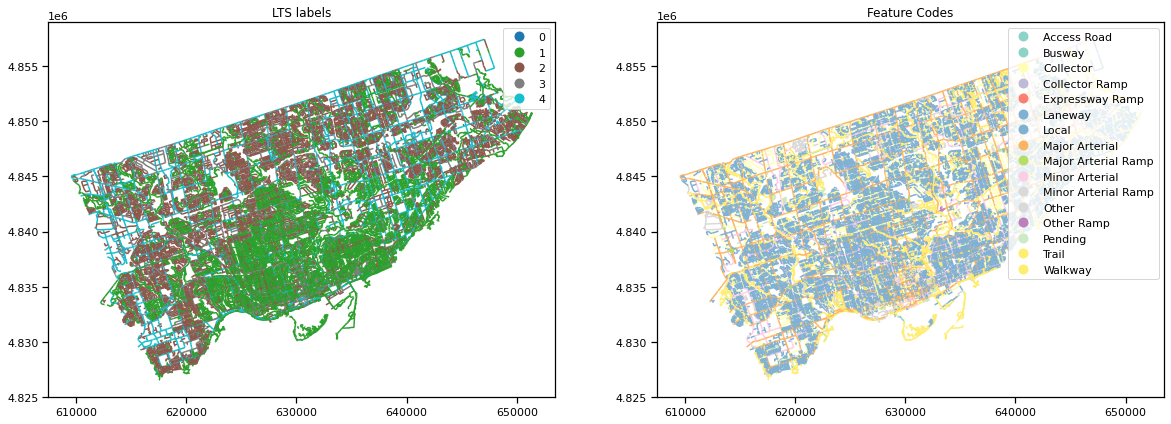

In [68]:
#Plot the LTS and feature descriptions to ensure the merge worked
fig, axs = plt.subplots(figsize=(20,12), ncols=2, nrows=1)

# Plotting
centre_merge.plot(ax=axs[0], column=centre_merge['LTS str'], legend=True)
centre_merge.plot(ax=axs[1], column='FEATURE_CODE_DESC', legend=True, cmap='Set3')

# Attributes
axs[0].title.set_text('LTS labels')
axs[1].title.set_text('Feature Codes')

fig.savefig('Features and LTS')

#### Look for statistical relationships, breakdown the feature codes in the dataframe.
It looks like from the graph that we can easily group some feature codes together with others <br>
##### NOTE!!! we actually probably don't want to use the feature code descriptions, as they contain info that is used in determining LTS (data leakage)
https://journals.sagepub.com/doi/pdf/10.3141/2587-06 see the original paper that describes how to determine LTS. We don't want to use any of this stuff, or at least it if we have the data it should be part of a PCA that determines which are the most important features in classification of LTS. <br>
https://www.toronto.ca/wp-content/uploads/2018/01/950a-Road-Classification_Summary-Document.pdf how Toronto classifies roads

In [69]:
centre_merge['high access'] = centre_merge['LTS'].apply(lambda x: 1 if x <= 2 else 0)
centre_merge = centre_merge[centre_merge['LTS'] != 0]

In [70]:
centre_merge.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 59553 entries, 0 to 59553
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   OBJECTID           59553 non-null  int64   
 1   GEO_ID             59553 non-null  int64   
 2   LFN_ID             59553 non-null  int64   
 3   LF_NAME            59553 non-null  object  
 4   FNODE              59553 non-null  int64   
 5   TNODE              59553 non-null  int64   
 6   ONE_WAY_DI         59553 non-null  int64   
 7   length_in_         59553 non-null  float64 
 8   GEO_ID_1           59553 non-null  int64   
 9   LTS                59553 non-null  int64   
 10  Shape_Leng         59553 non-null  float64 
 11  geometry_x         59553 non-null  geometry
 12  CENTRELINE_ID      58626 non-null  float64 
 13  FEATURE_CODE       58626 non-null  float64 
 14  FEATURE_CODE_DESC  58626 non-null  object  
 15  LINEAR_NAME_TYPE   53963 non-null  object  
 

In [71]:
centre_merge['LTS'].unique()

array([1, 2, 3, 4], dtype=int64)

<AxesSubplot:>

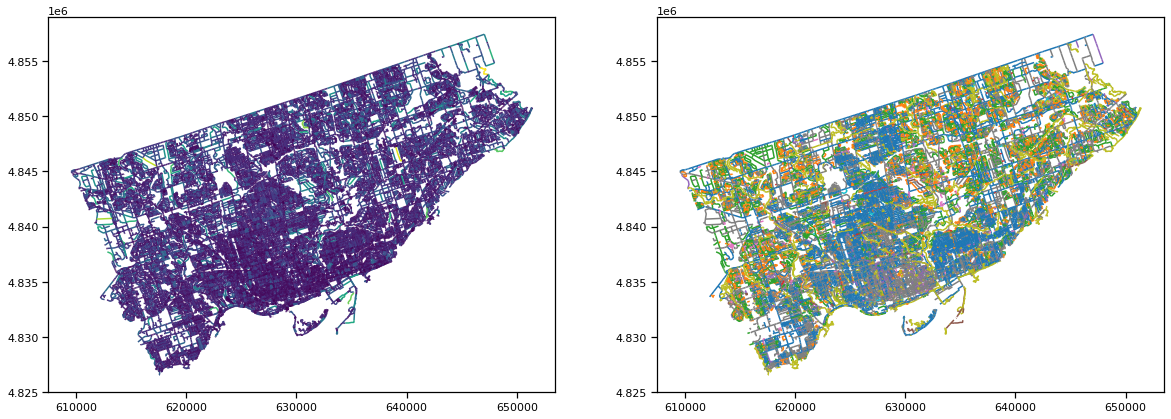

In [72]:
fig, axs = plt.subplots(figsize=(20,12), ncols=2, nrows=1)

# Plotting
centre_merge.plot(ax=axs[0], column='length_in_')
centre_merge.plot(ax=axs[1], column='LINEAR_NAME_TYPE')

In [73]:
centre_merge = centre_merge.rename({'geometry_x':'geometry'}, axis=1)

#### Also look a the bike lanes in the city.
This is from Toronto's open data. https://ckan0.cf.opendata.inter.prod-toronto.ca/en_AU/dataset/bikeways#:~:text=The%20Toronto%20bikeways%20data%20contains,part%20of%20the%20Bikeway%20Network. <br>
Though the rating criteria for LTS includes a bunch of details about bike lanes, seeing whether it is there or not might be enough of a feature to improve our model.

In [74]:
path_b = 'C:/Users/Keagan Rankin/Documents/PycharmProj/data/raw_data/Bikelane Data/bike-network-data-4326.geojson'
bikelane_gpd = gpd.read_file(path_b)
print(bikelane_gpd.shape)
bikelane_gpd.head()

(1262, 28)


,BYLAWED,CNPCLASS,DIR_HIGHORDER,DIR_LOWORDER,FROM_STREET,INFRA_HIGHORDER,INFRA_LOWORDER,INSTALLED,LAST_EDIT_DATE,OBJECTID,...,SEPB_HIGHORDER,SEPB_LOWORDER,STREET_NAME,SURFACE,Shape__Length,TO_STREET,UPGRADED,UPGRADE_DESCRIPTION,_id,geometry
0,Yes,Fast Busy Street,E,W,Highbourne Rd,Bike Lane,Bike Lane,2001,2019-08-15T16:04:01,1,...,None,None,Kilbarry Rd,Asphalt,128.045211,Oriole Pkwy,2007.0,None,1263,"MULTILINESTRING ((-79.40351 43.69526, -79.4030..."
1,N/A,Multi-Use Trail,E,W,Lake Shore Blvd W,Multi-Use Trail,MUT (2016 Network Plan/2012 Trails Plan),2001,2019-08-15T16:04:01,2,...,None,None,Martin Goodman / Waterfront Trl,Asphalt,128.686230,Martin Goodman Trl Branch,2009.0,None,1264,"MULTILINESTRING ((-79.40364 43.63499, -79.4035..."
2,N/A,Multi-Use Trail,E,W,Givendale Rd,Multi-Use Trail,MUT (2016 Network Plan/2012 Trails Plan),2001,2019-08-15T16:04:01,3,...,None,None,Gatineau Hydro Corridor Trl,Asphalt,379.789303,Kennedy Rd,2011.0,None,1265,"MULTILINESTRING ((-79.27522 43.74158, -79.2751..."
3,N/A,Multi-Use Trail,S,N,Dufferin St,Multi-Use Trail,MUT (2016 Network Plan/2012 Trails Plan),2001,2019-08-15T16:04:01,4,...,None,None,G Ross Lord Park Trl,Asphalt,552.499431,G Ross Lord Park Trl Branch,2011.0,None,1266,"MULTILINESTRING ((-79.46772 43.77208, -79.4675..."
4,N/A,Multi-Use Trail,S,N,Etobicoke Creek Trl Branch,Multi-Use Trail - Entrance,MUT - Entrance (2016 Network Plan/2012 Trails ...,2001,2019-08-15T16:04:01,5,...,None,None,Etobicoke Creek Trl,Asphalt,152.152899,Forty Third St,2012.0,None,1267,"MULTILINESTRING ((-79.54812 43.59027, -79.5480..."


In [75]:
# Merge the tags; We already know where the trails are, we just want the bikelanes on roads
bikelane_gpd['CNPCLASS'].unique()
streets = ['Fast Busy Street', 'Quiet Street' 'Fasy Busy Street']

bikelane_gpd = bikelane_gpd[bikelane_gpd['CNPCLASS'].isin(streets)]
print(bikelane_gpd.shape)
bikelane_gpd.head()
bikelane_gpd['INFRA_HIGHORDER'].unique()

# Filter to only Bike lane and cycle track

(316, 28)


array(['Bike Lane', 'Bike Lane - Buffered', 'Cycle Track', 'Edge Line',
       None, 'Signed Route (No Pavement Markings)', 'Sharrows - Arterial',
       'Sharrows', 'Sharrows - Wayfinding', 'Contraflow Cycle Track'],
      dtype=object)

In [76]:
# Merge the bikelane features info to the features frame.
bikelane_gpd_m = bikelane_gpd[['INFRA_HIGHORDER','STREET_NAME','geometry']].to_crs("EPSG:26917")

In [77]:
# limit the bikelane features to only seperated lanes and not sharrows or signed routes.
bikelane_gpd_m = bikelane_gpd_m[bikelane_gpd_m['INFRA_HIGHORDER'].isin(['Bike Lane','Bike Lane - Buffered','Cycle Track','Contraflow Cycle Track'])]
bikelane_gpd_m['INFRA_HIGHORDER'].unique()

array(['Bike Lane', 'Bike Lane - Buffered', 'Cycle Track',
       'Contraflow Cycle Track'], dtype=object)

In [78]:
bikelane_gpd_m['geometry'] = bikelane_gpd_m['geometry'].buffer(20)

In [79]:
# No relevant ID's in the bikelane data, so merge by geometry.
centre_merge_m = gpd.sjoin(centre_merge, #left
                         bikelane_gpd_m, #right
                         how='left',
                         op='within',
                        )

# We could also try merging on street name
#centre_merge_m = pd.merge(centre_merge,
#                        bikelane_gpd_m,
#                        how='left',
#                        left_on='LINEAR_NAME_FULL',
#                        right_on='STREET_NAME',
#                       )

print(centre_merge_m.shape)
centre_merge_m.head(2)

(59570, 23)


,OBJECTID,GEO_ID,LFN_ID,LF_NAME,FNODE,TNODE,ONE_WAY_DI,length_in_,GEO_ID_1,LTS,...,FEATURE_CODE,FEATURE_CODE_DESC,LINEAR_NAME_TYPE,LINEAR_NAME_FULL,geometry_y,LTS str,high access,index_right,INFRA_HIGHORDER,STREET_NAME
0,1,30079678,19155,Waterfront Trl,30079676,30079656,0,457.224811,30079678,1,...,204001.0,Trail,Trl,Waterfront Trl,"LINESTRING (617480.231 4826902.150, 617480.138...",1,1,NaN,NaN,NaN
1,2,30079680,19166,Marie Curtis Park Trl,30079676,30079679,0,35.226524,30079680,1,...,204001.0,Trail,Trl,Marie Curtis Park Trl,"LINESTRING (617480.231 4826902.150, 617476.262...",1,1,NaN,NaN,NaN


In [80]:
# Add a 'bikelane' column and fill Nas
centre_merge_m['STREET_NAME'] = centre_merge_m['STREET_NAME'].fillna(0)
centre_merge_m['STREET_NAME'] = centre_merge_m['STREET_NAME'].apply(lambda x: 0 if x == 0 else 1)
centre_merge_m = centre_merge_m.rename({'STREET_NAME':'bikelane'}, axis=1)

print(centre_merge_m.shape)
centre_merge_m = centre_merge_m.drop('index_right', axis=1)
centre_merge_m.head()

(59570, 23)


,OBJECTID,GEO_ID,LFN_ID,LF_NAME,FNODE,TNODE,ONE_WAY_DI,length_in_,GEO_ID_1,LTS,...,CENTRELINE_ID,FEATURE_CODE,FEATURE_CODE_DESC,LINEAR_NAME_TYPE,LINEAR_NAME_FULL,geometry_y,LTS str,high access,INFRA_HIGHORDER,bikelane
0,1,30079678,19155,Waterfront Trl,30079676,30079656,0,457.224811,30079678,1,...,30079678.0,204001.0,Trail,Trl,Waterfront Trl,"LINESTRING (617480.231 4826902.150, 617480.138...",1,1,NaN,0
1,2,30079680,19166,Marie Curtis Park Trl,30079676,30079679,0,35.226524,30079680,1,...,30079680.0,204001.0,Trail,Trl,Marie Curtis Park Trl,"LINESTRING (617480.231 4826902.150, 617476.262...",1,1,NaN,0
2,3,30079677,19155,Waterfront Trl,30008708,30079676,0,37.170074,30079677,1,...,30079677.0,204001.0,Trail,Trl,Waterfront Trl,"LINESTRING (617498.782 4826933.578, 617490.916...",1,1,NaN,0
3,4,30082310,10685,Island Rd,30008708,30082309,0,168.541328,30082310,1,...,30082310.0,201600.0,Other,Rd,Island Rd,"LINESTRING (617498.782 4826933.578, 617516.356...",1,1,NaN,0
4,5,30008940,19155,Waterfront Trl,30008711,30008708,0,84.289210,30008940,1,...,30008940.0,204001.0,Trail,Trl,Waterfront Trl,"LINESTRING (617552.626 4826998.138, 617541.915...",1,1,NaN,0


<AxesSubplot:>

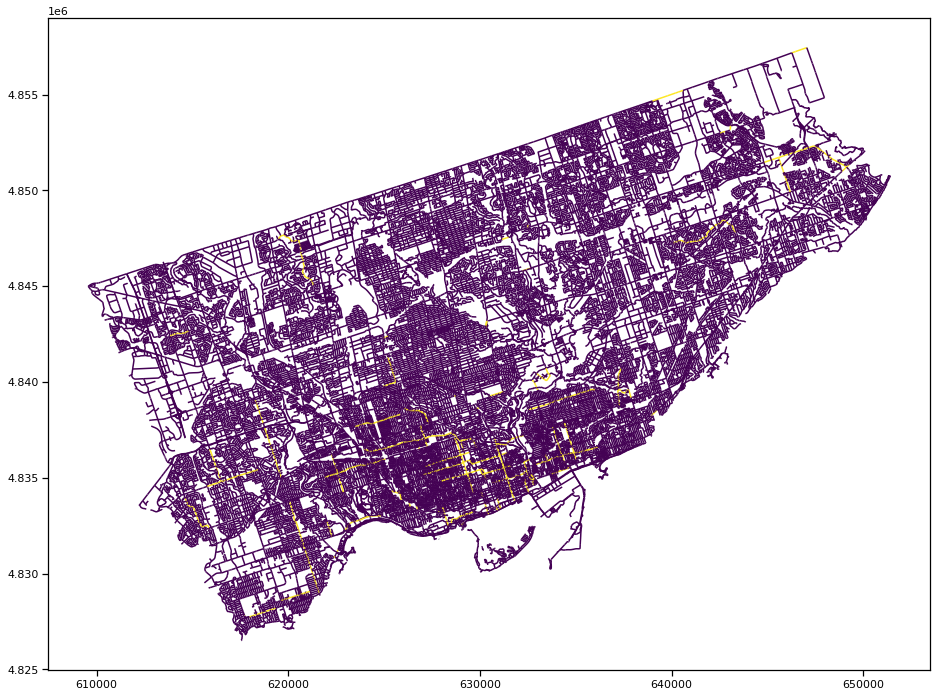

In [81]:
# Plot bikelane features
centre_merge_m = gpd.GeoDataFrame(centre_merge_m, geometry='geometry')
fig, axs = plt.subplots(figsize=(20,12))

# Plotting
centre_merge_m.plot(ax=axs, column='bikelane')

<AxesSubplot:>

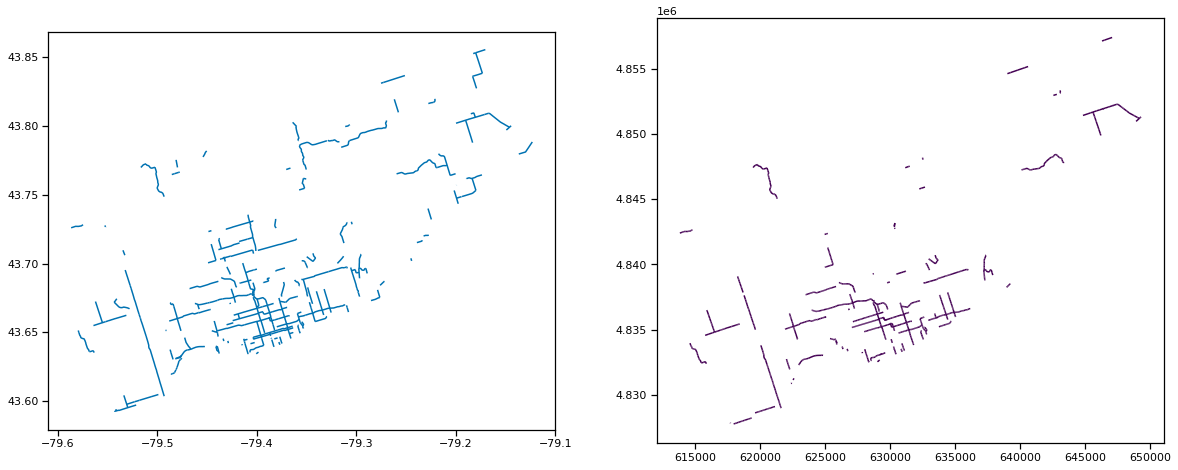

In [82]:
# Plot bike lanes to ensure the merge worked
fig, axs = plt.subplots(figsize=(20,12), ncols=2, nrows=1)
bikelane_gpd.plot(ax = axs[0])

plot_lanes = gpd.GeoDataFrame(centre_merge_m[centre_merge_m['bikelane'] == 1], geometry='geometry')
plot_lanes.plot(ax=axs[1], column='bikelane')

<AxesSubplot:>

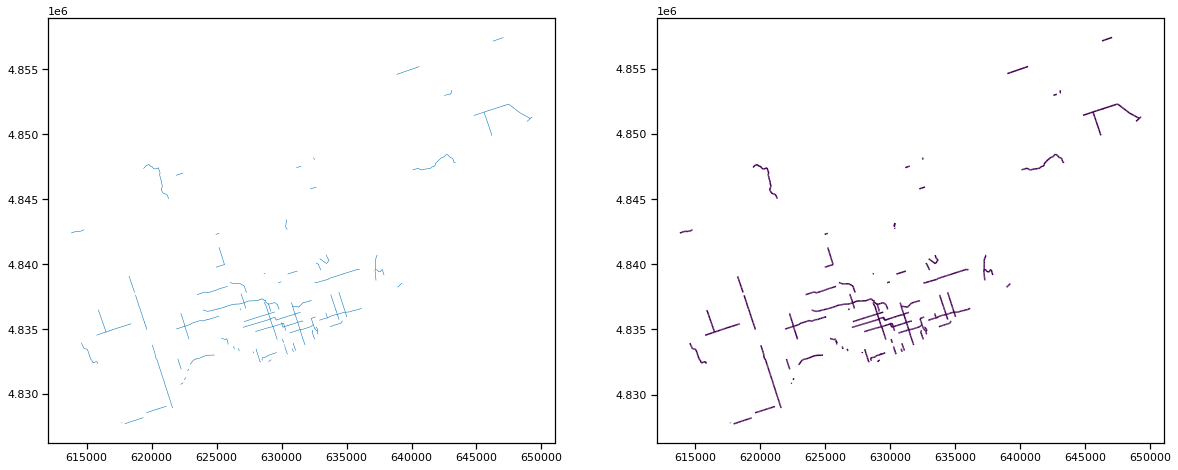

In [83]:
# Plot bike lanes to ensure the merge worked
fig, axs = plt.subplots(figsize=(20,12), ncols=2, nrows=1)
bikelane_gpd_m.plot(ax = axs[0])

plot_lanes = gpd.GeoDataFrame(centre_merge_m[centre_merge_m['bikelane'] == 1], geometry='geometry')
plot_lanes.plot(ax=axs[1], column='bikelane')

#### Neighbourhood for spatial cross validation
Before test train splitting our data, we want to add the neighbourhood/k-mean cluster labels to the data so that spatial CV can be performed.

In [84]:
# Import the neighbourhood data and format it correctly.
fp_k, fp_k2 = 'C:/Users/Keagan Rankin/Documents/PycharmProj/data/raw_data/Neighbourhood Data/neighbourhood-profiles-2016-csv (1).csv', \
              'C:/Users/Keagan Rankin/Documents/PycharmProj/data/raw_data/Neighbourhood Data/Neighbourhoods.geojson'

# Make adjustments
neighbourhood_boundaries = gpd.read_file(fp_k2)
neighbourhood_metre = neighbourhood_boundaries.to_crs("EPSG:26917")
neighbourhood_metre = neighbourhood_metre[['geometry','AREA_ID']]

In [85]:
# Merge the two datasets, drop irrelevant information, fillnas if needed
centre_merge_m = gpd.sjoin(centre_merge_m, #left
                         neighbourhood_metre, #right
                         how='left',
                         op='within',
                        )

In [86]:
centre_merge_m['AREA_ID'] = centre_merge_m['AREA_ID'].fillna(101)
centre_merge_m = centre_merge_m.drop('index_right',axis=1)

test train split the data to go into the road_feature_model

In [87]:
# one last look
centre_merge_m.head()

,OBJECTID,GEO_ID,LFN_ID,LF_NAME,FNODE,TNODE,ONE_WAY_DI,length_in_,GEO_ID_1,LTS,...,FEATURE_CODE,FEATURE_CODE_DESC,LINEAR_NAME_TYPE,LINEAR_NAME_FULL,geometry_y,LTS str,high access,INFRA_HIGHORDER,bikelane,AREA_ID
0,1,30079678,19155,Waterfront Trl,30079676,30079656,0,457.224811,30079678,1,...,204001.0,Trail,Trl,Waterfront Trl,"LINESTRING (617480.231 4826902.150, 617480.138...",1,1,NaN,0,101.0
1,2,30079680,19166,Marie Curtis Park Trl,30079676,30079679,0,35.226524,30079680,1,...,204001.0,Trail,Trl,Marie Curtis Park Trl,"LINESTRING (617480.231 4826902.150, 617476.262...",1,1,NaN,0,2480159.0
2,3,30079677,19155,Waterfront Trl,30008708,30079676,0,37.170074,30079677,1,...,204001.0,Trail,Trl,Waterfront Trl,"LINESTRING (617498.782 4826933.578, 617490.916...",1,1,NaN,0,2480159.0
3,4,30082310,10685,Island Rd,30008708,30082309,0,168.541328,30082310,1,...,201600.0,Other,Rd,Island Rd,"LINESTRING (617498.782 4826933.578, 617516.356...",1,1,NaN,0,2480159.0
4,5,30008940,19155,Waterfront Trl,30008711,30008708,0,84.289210,30008940,1,...,204001.0,Trail,Trl,Waterfront Trl,"LINESTRING (617552.626 4826998.138, 617541.915...",1,1,NaN,0,2480159.0


In [88]:
# Do a 80/20 test train split and save these to a csv
from sklearn.model_selection import train_test_split

#stratify the split across the LTS labels
train, test = train_test_split(centre_merge_m, test_size=0.2, stratify=centre_merge_m['LTS'])
print('Train:', train.shape, 'Test:', test.shape)
print('LTS 1 Train proportion: {:.2f} %'.format(train['LTS'][train['LTS'] == 1].shape[0] / train.shape[0] * 100))
print('LTS 1 Test proportion: {:.2f} %'.format(test['LTS'][test['LTS'] == 1].shape[0] / test.shape[0] * 100))

Train: (47656, 23) Test: (11914, 23)
LTS 1 Train proportion: 51.99 %
LTS 1 Test proportion: 51.99 %


In [89]:
train.to_csv('centrelinebike_train_spatial_2.csv')
test.to_csv('centrelinebike_test_spatial_2.csv')

 This could be a very useful alternative to the rigid classification methods from teh 2016 paper. <br>
 many cities in North America classify their roads into 4 or 5 common road types (Major Arterial, Minor Arterial, Collector, Local).
 according to TAC: https://www.toronto.ca/services-payments/streets-parking-transportation/traffic-management/road-classification-system/about-the-road-classification-system/ <br>
 For example: all of the municipalities in Quebec https://open.canada.ca/data/en/dataset/c937deb0-a089-4035-88f1-06b36bfd42c5 <br>
 Vancouver: https://opendata.vancouver.ca/explore/dataset/public-streets/map/?location=10,49.1826,-122.76535